This notebook is used to play around with an Hadoop environment. Firstly, I will extract data from a website, show some statistics and some plots. Next I will create a CSV and create a MapReduce script to play with the data.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
import platform
platform.python_version()

'3.6.2'

## Extracting the data
Credit to http://videogamecritic.com/nes.htm for making a nice list to work with.

In [2]:
import lxml.html
import requests

In [3]:
URL = 'http://videogamecritic.com/nes.htm'
resp = requests.get(URL)
if resp.status_code != 200:
        raise Exception('GET '+link+' {}'.format(resp.status_code))
data = lxml.html.fromstring(resp.content)
gamepages = ['http://videogamecritic.com/' + game.get('href') for game in data.cssselect('h3 a')]
gamepages

['http://videogamecritic.com/nesaa.htm',
 'http://videogamecritic.com/nesbb.htm',
 'http://videogamecritic.com/nescc.htm',
 'http://videogamecritic.com/nesde.htm',
 'http://videogamecritic.com/nesfh.htm',
 'http://videogamecritic.com/nesil.htm',
 'http://videogamecritic.com/nesmn.htm',
 'http://videogamecritic.com/nesor.htm',
 'http://videogamecritic.com/nesss.htm',
 'http://videogamecritic.com/nestt.htm',
 'http://videogamecritic.com/nesuz.htm']

Note: I have a Docker container running with Selenium instead of installing all dependencies on my system. See [this page](https://hub.docker.com/r/selenium/standalone-chrome/).

In [4]:
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
driver = webdriver.Remote("http://66.70.222.43:4444/wd/hub", DesiredCapabilities.CHROME)

In [5]:
gamedata = []
for page in gamepages:
    # Retrieve the data
    driver.get(page)
    data = lxml.html.fromstring(driver.page_source)
    # Extract the fields
    grades = [elem.text_content() for elem in data.cssselect('div[class*=\'hdr\']')]
    names = [elem.text_content() for elem in data.cssselect('div[class*=\'hdl\']')]
    metadata = [elem.text_content() for elem in data.cssselect('div[class*=\'mdl\']')]
    votes = [elem.text_content() for elem in data.cssselect('div[class*=\'vote\']')]
    # Append to dataset
    gamedata += list(zip(names, votes, grades, metadata))


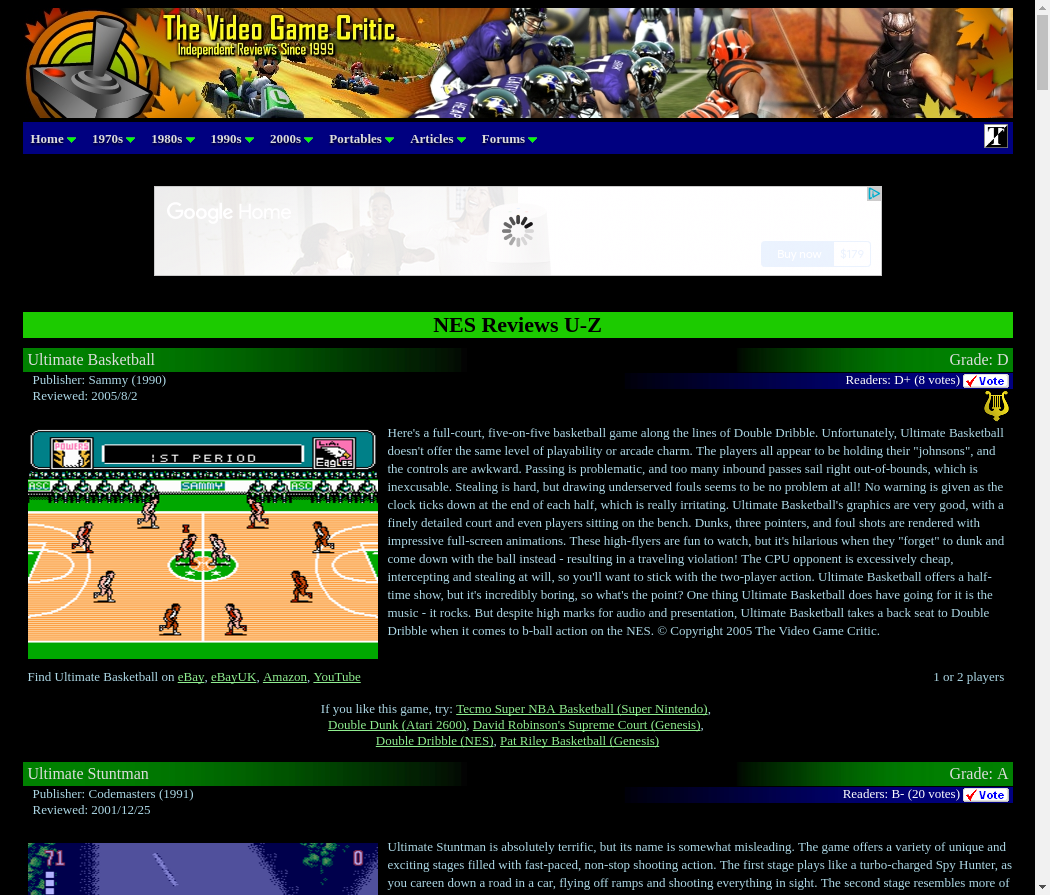

In [6]:
# Bonus: screenshot of the page
image = driver.get_screenshot_as_base64()
from IPython.display import HTML
HTML("""<img src="data:image/png;base64,{0}">""".format(image))

In [7]:
driver.quit()

## Cleaning the data

In [8]:
import pandas as pd

In [9]:
def map_rating(rating):
    """ Function to convert the rating to a number """
    if (rating == "A+"): return 1;
    if (rating == "A"): return 2;
    if (rating == "A-"): return 3;
    if (rating == "B+"): return 4;
    if (rating == "B"): return 5;
    if (rating == "B-"): return 6;
    if (rating == "C+"): return 7;
    if (rating == "C"): return 8;
    if (rating == "C-"): return 9;
    if (rating == "D+"): return 10;
    if (rating == "D"): return 11;
    if (rating == "D-"): return 12;
    if (rating == "F"): return 13;
    if (rating == "F-"): return 14;
    return 15;

In [10]:
df = pd.DataFrame.from_dict(gamedata)
df = df.rename(columns={0: "name", 1: "vote", 2: "grade", 3: "publisher"})

In [11]:
# Extract and convert data
df['reader_rating'] = df['vote'].str.extract('Readers:\s(.*?)\s\(', expand=True)
df['reader_rating']  = df['reader_rating'].apply(lambda x: map_rating(x)).astype('int')
df['number_of_votes'] = df['vote'].str.extract('\((\d*)\svotes\)', expand=True).astype('int')
df['grade'] = df['grade'].str.replace("Grade:", "").str.strip().apply(lambda x: map_rating(x)).astype('int')
df['publish_year'] = df['publisher'].str.extract('\((\d*)\)Reviewed', expand=True)
df['publisher'] = df['publisher'].str.extract("Publisher:\s(.*?)\s\(", expand=True)
df.drop('vote', axis=1, inplace=True)
# Calculate the total grade
df['total_grade'] = (df['grade'] + df['reader_rating']*df['number_of_votes']) / (df['number_of_votes']+1)
# Corrections
df['publisher'] = df['publisher'].str.replace('Electrobrain', 'Electro Brain')

In [12]:
df.dtypes

name                object
grade                int64
publisher           object
reader_rating        int64
number_of_votes      int64
publish_year        object
total_grade        float64
dtype: object

In [13]:
df.head()

,name,grade,publisher,reader_rating,number_of_votes,publish_year,total_grade
0,10-Yard Fight,12,Nintendo,10,44,1985,10.044444
1,1942,11,Capcom,8,66,1985,8.044776
2,1943,5,Capcom,4,58,1988,4.016949
3,720 Degrees,13,Tengen,11,24,1989,11.080000
4,8 Eyes,13,Taxan,10,30,1989,10.096774


## Calculate statistics

In [14]:
# The best game
df.loc[df['total_grade'].idxmin()]['name']

"Mike Tyson's Punch-Out!!"

In [15]:
# The worst game
df.loc[df['total_grade'].idxmax()]['name']

"Dragon's Lair"

In [16]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

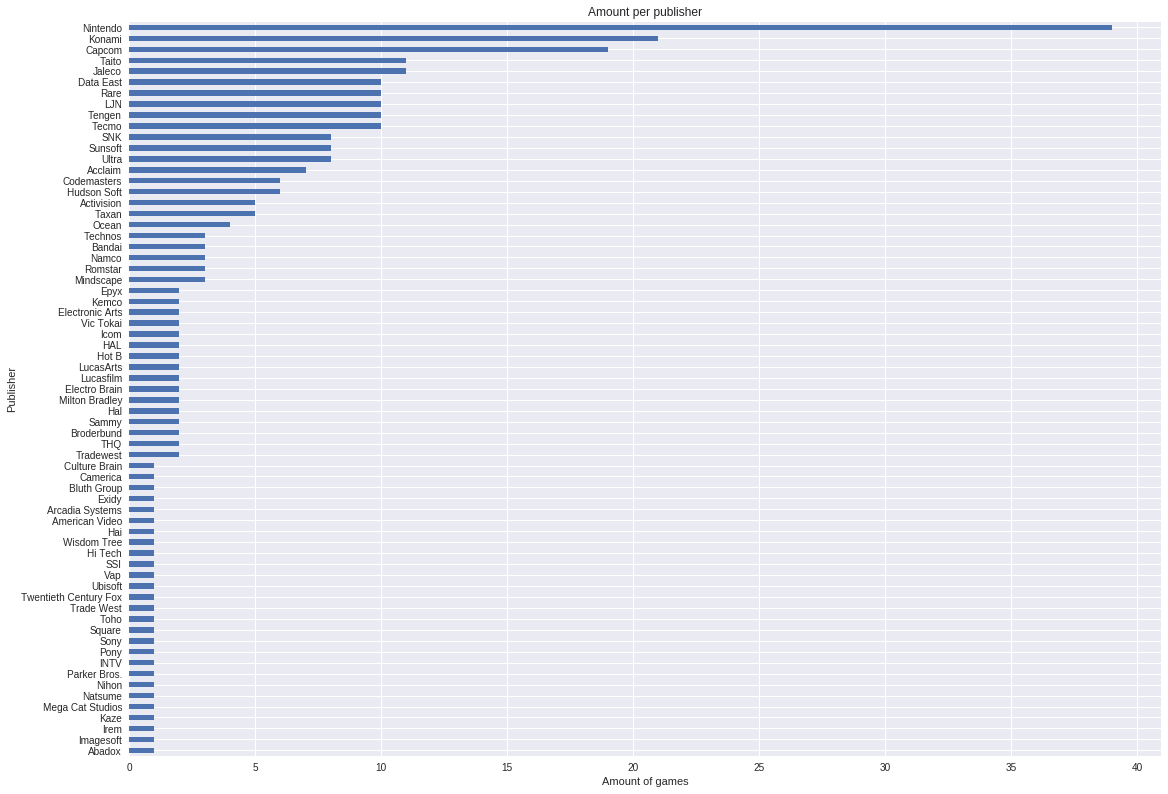

In [17]:
df.groupby('publisher')['name'].count().sort_values(ascending=True).plot.barh(title='Amount per publisher');
plt.ylabel('Publisher');
plt.xlabel('Amount of games');
fig = plt.gcf();
fig.set_size_inches(18.5, 13.5);

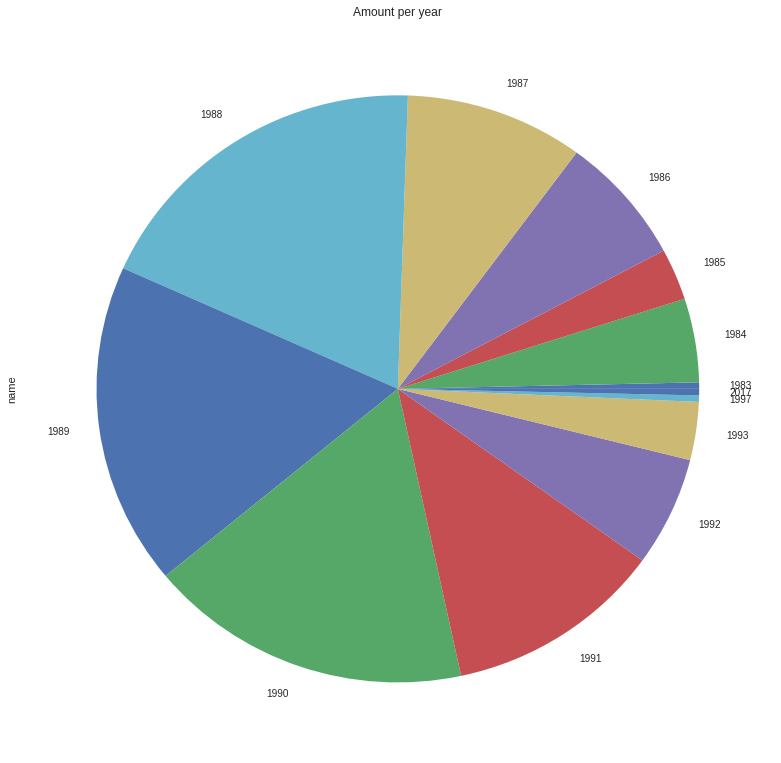

In [18]:
df.groupby('publish_year')['name'].count().plot.pie(title='Amount per year');
fig = plt.gcf();
fig.set_size_inches(13.5, 13.5);

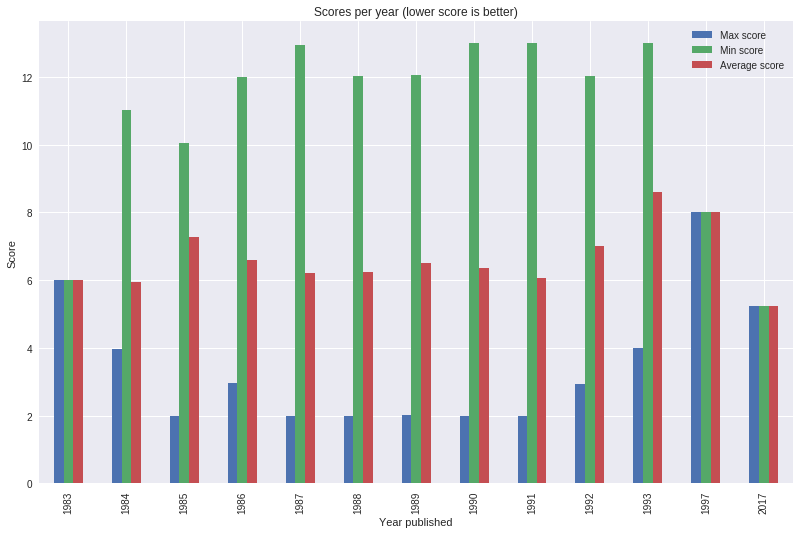

In [19]:
pd.concat(
    [df.groupby('publish_year')['total_grade'].min().rename('Max score'),
     df.groupby('publish_year')['total_grade'].max().rename('Min score'),
     df.groupby('publish_year')['total_grade'].mean().rename('Average score')], axis=1
).plot.bar(title='Scores per year (lower score is better)')
plt.xlabel('Year published');
plt.ylabel('Score');
fig = plt.gcf();
fig.set_size_inches(13.5, 8.5);

In [20]:
df.to_csv('../data/nesgamedata.csv', sep='\t', header=False)

In [21]:
!head ../data/nesgamedata.csv

0	10-Yard Fight	12	Nintendo	10	44	1985	10.044444444444444
1	1942	11	Capcom	8	66	1985	8.044776119402986
2	1943	5	Capcom	4	58	1988	4.016949152542373
3	720 Degrees	13	Tengen	11	24	1989	11.08
4	8 Eyes	13	Taxan	10	30	1989	10.096774193548388
5	Abadox	11	Abadox	6	35	1989	6.138888888888889
6	Adventure Island	7	Hudson Soft	6	64	1987	6.015384615384615
7	Adventure Island 2	4	Hudson Soft	5	41	1990	4.976190476190476
8	Adventure Island 3	4	Hudson Soft	5	27	1992	4.964285714285714
9	Adventures in the Magic Kingdom	5	Capcom	8	23	1990	7.875


## MapReduce
Calculate how often what rating is used.
1. Map the reader ratings
2. Reduce to counts per rating

Lets create the script that will perform my first MapReduce action. The content of the following cell will be saved to a file which can in turn be used to perform the mapping and reducing.

In [22]:
%%file gamesbreakdown.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class GamesBreakdown(MRJob):
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_ratings,
                   reducer=self.reducer_count_ratings)
        ]
    
    def mapper_get_ratings(self, _, line):
        (index, name, grade, publisher, reader_rating, number_of_votes, publish_year, total_grade) = line.split('\t') 
        yield reader_rating, 1
        
    def reducer_count_ratings(self, key, values):
        yield key, sum(values)
        
if __name__ == '__main__':
    GamesBreakdown.run()

Writing gamesbreakdown.py


In [23]:
from IPython.display import FileLink
FileLink('gamesbreakdown.py')

/opt/notebooks/gamesbreakdown.py

One way to run the script is from the command line. Note that this script will not use Hadoop in this case. 

In [24]:
!python gamesbreakdown.py ../data/nesgamedata.csv

No configs found; falling back on auto-configuration
Creating temp directory /tmp/gamesbreakdown.jovyan.20170922.141459.019533
Running step 1 of 1...
Streaming final output from /tmp/gamesbreakdown.jovyan.20170922.141459.019533/output...
"10"	15
"11"	14
"12"	12
"13"	4
"2"	9
"3"	29
"4"	42
"5"	36
"6"	48
"7"	30
"8"	29
"9"	14
Removing temp directory /tmp/gamesbreakdown.jovyan.20170922.141459.019533...


Another way is to run it from within a cell.

In [25]:
from importlib import reload
import gamesbreakdown
reload(gamesbreakdown)

mr_job = gamesbreakdown.GamesBreakdown(args=['../data/nesgamedata.csv'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        print(key, value)

<module 'gamesbreakdown' from '/opt/notebooks/gamesbreakdown.py'>

10 15
11 14
12 12
13 4
2 9
3 29
4 42
5 36
6 48
7 30
8 29
9 14


To use Hadoop, the command should look like the following and should be run on the Hadoop machine, with the hadoop-streaming-jar argument only given in case the .jar is not found:
```shell
python gamesbreakdown.py -r hadoop --hadoop-streaming-jar /usr/hdp/current/hadoop-mapreduce-client/hadoop-streaming.jar nesgamedata.csv
```
To do this, upload the `nesgamesdata.csv` file and the script `gamesbreakdown.py` to HDFS, using the Hue files view and upload functionality. Next copy them to the local folder to be used in the command. Of course other methods to get the files locally on the Hadoop machine can be used.

I am using the [Cloudera Quickstart image](https://hub.docker.com/r/cloudera/quickstart/) to experiment with Docker and Cloudera and the `docker-compose.yml` contains the following:
```
version: '2'
services:
  cloudera:
    hostname: quickstart.cloudera
    command: /usr/bin/docker-quickstart
    tty: true
    privileged: true
    image: cloudera/quickstart:latest
    volumes:
      - ./data:/opt/data
    ports:
      - "8020:8020"
      - "8022:22"     # ssh
      - "7180:7180"   # Cloudera Manager
      - "8888:8888"   # HUE
      - "11000:11000" # Oozie
      - "50070:50070" # HDFS REST Namenode
      - "2181:2181"
      - "11443:11443"
      - "9090:9090"
      - "8088:8088"
      - "19888:19888"
      - "9092:9092"
      - "8983:8983"
      - "16000:16000"
      - "16001:16001"
      - "42222:22"
      - "8042:8042"
      - "60010:60010"
      - "8080:8080"
      - "7077:7077"

```
Connect to the machine and verify the file is present:
```shell
jitsejan@ssdnodes-jj-kvm:~/cloudera_docker$ docker exec -ti clouderadocker_cloudera_1 bash
[root@quickstart /]# cd home/
[root@quickstart home]# mkdir gamedata && cd $_
[root@quickstart gamedata]# hadoop fs -get gamedata/gamesbreakdown.py gamesbreakdown.py
[root@quickstart gamedata]# hadoop fs -get gamedata/nesgamedata.csv nesgamedata.csv
[root@quickstart gamedata]# ll
total 20
-rw-r--r-- 1 root root   590 Sep  5 13:42 gamesbreakdown.py
-rw-r--r-- 1 root root 15095 Sep  5 13:56 nesgamedata.csv
```

Install the mrjob library on the Cloudera container
```shell
[root@quickstart gamedata]# yum install python-pip -y
[root@quickstart gamedata]# pip install mrjob
```

Run the script without using Hadoop to verify the installation.
```shell
[root@quickstart gamedata]# python gamesbreakdown.py nesgamedata.csv
No configs found; falling back on auto-configuration
Creating temp directory /tmp/gamesbreakdown.root.20170905.135809.859796
Running step 1 of 1...
Streaming final output from /tmp/gamesbreakdown.root.20170905.135809.859796/output...
"10"    15
"11"    14
"12"    12
"13"    4
"2"     9
"3"     28
"4"     44
"5"     34
"6"     48
"7"     31
"8"     28
"9"     15
Removing temp directory /tmp/gamesbreakdown.root.20170905.135809.859796...
```

Now use Hadoop to start the cluster magic.
```shell
[root@quickstart gamedata]# python gamesbreakdown.py -r hadoop nesgamedata.csv
No configs found; falling back on auto-configuration
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/gamesbreakdown.root.20170905.135908.241472
Copying local files to hdfs:///user/root/tmp/mrjob/gamesbreakdown.root.20170905.135908.241472/files/...
Running step 1 of 1...
  packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob3556720292725669631.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1504618114531_0001
  Submitted application application_1504618114531_0001
  The url to track the job: http://quickstart.cloudera:8088/proxy/application_1504618114531_0001/
  Running job: job_1504618114531_0001
  Job job_1504618114531_0001 running in uber mode : false
   map 0% reduce 0%
   map 50% reduce 0%
   map 100% reduce 0%
   map 100% reduce 100%
  Job job_1504618114531_0001 completed successfully
  Output directory: hdfs:///user/root/tmp/mrjob/gamesbreakdown.root.20170905.135908.241472/output
Counters: 49
        File Input Format Counters
                Bytes Read=19191
        File Output Format Counters
                Bytes Written=86
        File System Counters
                FILE: Number of bytes read=2307
                FILE: Number of bytes written=358424
                FILE: Number of large read operations=0
                FILE: Number of read operations=0
                FILE: Number of write operations=0
                HDFS: Number of bytes read=19527
                HDFS: Number of bytes written=86
                HDFS: Number of large read operations=0
                HDFS: Number of read operations=9
                HDFS: Number of write operations=2
        Job Counters
                Data-local map tasks=2
                Launched map tasks=2
                Launched reduce tasks=1
                Total megabyte-seconds taken by all map tasks=8678400
                Total megabyte-seconds taken by all reduce tasks=3588096
                Total time spent by all map tasks (ms)=8475
                Total time spent by all maps in occupied slots (ms)=8475
                Total time spent by all reduce tasks (ms)=3504
                Total time spent by all reduces in occupied slots (ms)=3504
                Total vcore-seconds taken by all map tasks=8475
                Total vcore-seconds taken by all reduce tasks=3504
        Map-Reduce Framework
                CPU time spent (ms)=2450
                Combine input records=0
                Combine output records=0
                Failed Shuffles=0
                GC time elapsed (ms)=367
                Input split bytes=336
                Map input records=282
                Map output bytes=1737
                Map output materialized bytes=2313
                Map output records=282
                Merged Map outputs=2
                Physical memory (bytes) snapshot=651063296
                Reduce input groups=12
                Reduce input records=282
                Reduce output records=12
                Reduce shuffle bytes=2313
                Shuffled Maps =2
                Spilled Records=564
                Total committed heap usage (bytes)=679477248
                Virtual memory (bytes) snapshot=4099473408
        Shuffle Errors
                BAD_ID=0
                CONNECTION=0
                IO_ERROR=0
                WRONG_LENGTH=0
                WRONG_MAP=0
                WRONG_REDUCE=0
Streaming final output from hdfs:///user/root/tmp/mrjob/gamesbreakdown.root.20170905.135908.241472/output...
"10"    15
"11"    14
"12"    12
"13"    4
"2"     9
"3"     28
"4"     44
"5"     34
"6"     48
"7"     31
"8"     28
"9"     15
Removing HDFS temp directory hdfs:///user/root/tmp/mrjob/gamesbreakdown.root.20170905.135908.241472...
Removing temp directory /tmp/gamesbreakdown.root.20170905.135908.241472...
```

### Update the MapReduce script
Now lets add another reducer step to sort the counts of the ratings.

In [26]:
%%file gamesbreakdownupdate.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class GamesBreakdownUpdate(MRJob):
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_ratings,
                   reducer=self.reducer_count_ratings),
            MRStep(reducer=self.reducer_sorted_output)
        ]
    
    def mapper_get_ratings(self, _, line):
        (index, name, grade, publisher, reader_rating, number_of_votes, publish_year, total_grade) = line.split('\t') 
        yield reader_rating, 1
        
    def reducer_count_ratings(self, key, values):
        yield str(sum(values)).zfill(2), key
        
    def reducer_sorted_output(self, count, ratings):
        for rating in ratings:
            yield rating, count
        
if __name__ == '__main__':
    GamesBreakdownUpdate.run()

Overwriting gamesbreakdownupdate.py


In [27]:
!python gamesbreakdownupdate.py ../data/nesgamedata.csv

No configs found; falling back on auto-configuration
Creating temp directory /tmp/gamesbreakdownupdate.jovyan.20170922.141459.633146
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/gamesbreakdownupdate.jovyan.20170922.141459.633146/output...
"13"	"04"
"2"	"09"
"12"	"12"
"11"	"14"
"9"	"14"
"10"	"15"
"3"	"29"
"8"	"29"
"7"	"30"
"5"	"36"
"4"	"42"
"6"	"48"
Removing temp directory /tmp/gamesbreakdownupdate.jovyan.20170922.141459.633146...


## Pig
Using the [Pig language](https://pig.apache.org/docs/r0.7.0/piglatin_ref2.html), we can make a script to perform the MapReduce actions

In [28]:
%%file gamedata_01.pig
gamedata = LOAD 'nesgamedata.csv' AS (index:int, name:chararray, grade:chararray, publisher:chararray, reader_rating:chararray, number_of_votes:int, publish_year:int, total_grade:chararray);

DESCRIBE gamedata;

DUMP gamedata;

Overwriting gamedata_01.pig


```
[root@quickstart gamedata]# pig -f gamedata_01.pig
...
(269,Winter Games,12,Epyx,13,24,1987,12.96)
(270,Wizards and Warriors,9,Rare,6,55,1987,6.053571428571429)
(271,World Games,6,Epyx,9,8,1986,8.666666666666666)
(272,Wrath of the Black Manta,7,Taito,6,31,1989,6.03125)
(273,Wrecking Crew,10,Nintendo,8,18,1985,8.105263157894736)
(274,Xevious,5,Namco,6,36,1988,5.972972972972973)
(275,Xexyz,10,Hudson Soft,5,26,1989,5.185185185185185)
(276,Yoshi,5,Nintendo,6,41,1992,5.976190476190476)
(277,Yoshi's Cookie,5,Nintendo,7,23,1993,6.916666666666667)
(278,Zanac,2,Pony,3,21,1986,2.9545454545454546)
(279,Zelda II: The Adventure of Link,3,Nintendo,4,112,1989,3.9911504424778763)
(280,Zelda, The Legend of,3,Nintendo,3,140,1986,3.0)
(281,Zombie Nation,4,Kaze,8,26,1991,7.851851851851852)

```

Now lets calculate the average rating given by users for each different rating given by the author of the website for all Nintendo games.

In [29]:
%%file gamedata_02.pig
gamedata = LOAD 'nesgamedata.csv' AS (index:int, name:chararray, grade:int, publisher:chararray, reader_rating:int, number_of_votes:int, publish_year:int, total_grade:float);

gamesNintendo = FILTER gamedata BY publisher == 'Nintendo';

gamesRatings = GROUP gamesNintendo BY grade;

averaged = FOREACH gamesRatings GENERATE group as rating,
        AVG(gamesNintendo.total_grade) AS avgRating;

DUMP averaged;

Overwriting gamedata_02.pig


Run the script on the Hadoop machine:
```
[root@quickstart gamedata]# pig -f gamedata_02.pig
...
(1,2.321279764175415)
(2,3.3024109601974487)
(3,3.7930258750915526)
(4,3.0212767124176025)
(5,5.381512546539307)
(6,5.773015689849854)
(7,6.020833492279053)
(8,9.833333015441895)
(9,6.624411582946777)
(10,8.105262756347656)
(12,8.070609092712402)
(13,10.066511631011963)
```

From this we can observe that on average the users do not really agree on the ratings with the author. Often the author gives higher grades to a game than the  users.

## Spark
Next lets start playing with Spark. I will use the [Docker image](https://hub.docker.com/r/sequenceiq/spark/) from SequenceIQ.

In [30]:
from pyspark import SparkConf, SparkContext
import collections

### Configure the Spark connection

In [31]:
conf = SparkConf().setMaster("local").setAppName("GameRatings")
sc = SparkContext(conf = conf)

Verify that the Spark context is working by creating a random RDD of 1000 values and pick 5 values.

In [32]:
rdd = sc.parallelize(range(1000))
rdd.takeSample(False, 5)

[820, 967, 306, 62, 448]

Next we can create an RDD from the data from before.

In [33]:
lines = sc.textFile("../data/nesgamedata.csv")

Lets calculate the average rating of the voters compared to the votes of the author.

In [34]:
def parseLine(line):
    fields = line.split('\t')
    index = int(fields[0])
    name = fields[1]
    grade = float(fields[2])
    publisher = fields[3]
    reader_rating = float(fields[4])
    number_of_votes = int(fields[5])
    publish_year = int(fields[6])
    total_grade = float(fields[7])
    return (grade, total_grade, name, publisher, reader_rating, number_of_votes, publish_year)

We return the grade and the total grade as a tuple from the `parseLine` function.

In [35]:
games_rdd = lines.map(parseLine)
games_rdd.take(2)

[(12.0, 10.044444444444444, '10-Yard Fight', 'Nintendo', 10.0, 44, 1985),
 (11.0, 8.044776119402986, '1942', 'Capcom', 8.0, 66, 1985)]

Add a 1 to each line so we can sum the `total_grades`.

In [36]:
games_mapped = games_rdd.mapValues(lambda x: (x, 1))

In [37]:
games_mapped.take(2)

[(12.0, (10.044444444444444, 1)), (11.0, (8.044776119402986, 1))]

Sum all `total_grades` by using the key `grade`. For each row this will sum the grades and it will sum the 1's that we've added.

In [38]:
games_reduced = games_mapped.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

In [39]:
games_reduced.take(2)

[(12.0, (70.26902777777778, 7)), (11.0, (193.88550134591918, 25))]

Calculate the average `total_grade` for each `grade`.

In [40]:
average_grade = games_reduced.mapValues(lambda x: x[0] / x[1])

In [41]:
results = average_grade.collect()

In [42]:
for result in results:
    print(result)

(12.0, 10.03843253968254)
(11.0, 7.755420053836767)
(5.0, 5.05270714136425)
(13.0, 10.26375094258694)
(7.0, 6.212705308155384)
(4.0, 4.909347517549459)
(8.0, 7.0328696656678105)
(9.0, 6.519739721431783)
(6.0, 5.63766311790758)
(2.0, 3.495086595355065)
(3.0, 4.1090931800649315)
(10.0, 6.9165990377786555)
(1.0, 2.321295734457781)


Filter out all Nintendo games, where the publisher is the 4-th element in the row.

In [43]:
nintendoGames = games_rdd.filter(lambda x: 'Nintendo' in x[3])
nintendoGames.take(2)

[(12.0, 10.044444444444444, '10-Yard Fight', 'Nintendo', 10.0, 44, 1985),
 (5.0, 4.014705882352941, 'Balloon Fight', 'Nintendo', 4.0, 67, 1984)]

Take the year and the total grade.

In [44]:
nintendoYears = nintendoGames.map(lambda x: (x[-1], x[1]))
nintendoYears.take(2)

[(1985, 10.044444444444444), (1984, 4.014705882352941)]

Calculate the minimum grade for each year.

In [45]:
minYears = nintendoYears.reduceByKey(lambda x, y: min(x,y))

In [46]:
results = minYears.collect()
for result in results:
    print('Year: {:d}\tMinimum score: {:.2f}'.format(result[0] , result[1]))

Year: 1985	Minimum score: 2.00
Year: 1984	Minimum score: 3.96
Year: 1991	Minimum score: 2.98
Year: 1990	Minimum score: 2.00
Year: 1989	Minimum score: 3.99
Year: 1988	Minimum score: 3.99
Year: 1986	Minimum score: 2.98
Year: 1987	Minimum score: 1.99
Year: 1983	Minimum score: 6.02
Year: 1992	Minimum score: 5.98
Year: 1993	Minimum score: 6.92


Lets try using FlatMap to count the most occurring words in the titles of the NES games.

In [47]:
words = games_rdd.flatMap(lambda x: x[2].split())

In [48]:
type(words)

pyspark.rdd.PipelinedRDD

In [49]:
words.take(10)

['10-Yard',
 'Fight',
 '1942',
 '1943',
 '720',
 'Degrees',
 '8',
 'Eyes',
 'Abadox',
 'Adventure']

In [50]:
wordCounts = words.map(lambda x: (x,1)).reduceByKey(lambda x, y: x + y)
wordCountsSorted = wordCounts.map(lambda x: (x[1],x[0])).sortByKey()
results = wordCountsSorted.collect()

In [51]:
for count, word in reversed(results):
    print(word, count)

The 20
of 17
Super 11
the 11
Baseball 9
and 8
2 8
Ninja 7
Man 7
II 7
Mega 6
3 6
Dragon 5
Adventure 5
Tecmo 4
Spy 4
version) 4
Warriors 4
Monster 4
Mario 4
Kong 4
Donkey 4
II: 4
2: 4
Adventures 4
Turtles 3
Mutant 3
Teenage 3
Bros. 3
Die 3
or 3
Robocop 3
Gaiden 3
Last 3
Doom 3
Jones 3
Indiana 3
Ikari 3
Golf 3
Star 3
Warrior 3
Legend 3
Double 3
Force 3
Rescue 3
Games 3
III: 3
Castlevania 3
Batman 3
Loaded 3
Bases 3
in 3
Island 3
Ultimate 2
Field 2
Track 2
Tetris 2
Project 2
Basketball 2
Bowl 2
Ball 2
Hunter 2
Skate 2
Renegade 2
Rad 2
RBI 2
Pro-Am 2
R.C. 2
Quattro 2
Pinball 2
World 2
Pocket 2
Rally 2
Punch-Out!! 2
(Aladdin 2
Machines 2
Micro 2
Kid 2
Karate 2
on 2
One 2
Crusade 2
Road 2
Ice 2
Alone 2
Home 2
Heavy 2
'N 2
Ghostbusters 2
Gauntlet 2
G.I. 2
Duck 2
New 2
Sword 2
City 2
Contra 2
Cobra 2
Quest 2
N 2
Castle 2
Black 2
Commando 2
Returns 2
Return 2
Stars 2
Wars 2
Jr. 2
Fight 2
Nation 1
Zombie 1
Zelda, 1
Link 1
Zelda 1
Zanac 1
Cookie 1
Yoshi's 1
Yoshi 1
Xexyz 1
Xevious 1
Crew 1
Wreckin

In [52]:
import re
def normalizeWords(text):
    """ Remove unwanted text """
    return re.compile(r'\W+', re.UNICODE).split(text[2].lower())

In [53]:
words_normalized = games_rdd.flatMap(normalizeWords)

In [54]:
words_normalized.take(2)

['10', 'yard']

In [55]:
wordNormCounts = words_normalized.countByValue()
for word, count in sorted(wordNormCounts.items(), key=lambda x: x[1], reverse=True):
    if word.encode('ascii', 'ignore'):
        print(word, count)

the 31
of 17
2 12
ii 11
super 11
baseball 9
s 9
and 8
3 7
man 7
ninja 7
dragon 6
mega 6
adventure 5
adventures 4
n 4
donkey 4
kong 4
mario 4
monster 4
warriors 4
version 4
c 4
spy 4
tecmo 4
island 3
in 3
stars 3
bases 3
loaded 3
batman 3
out 3
castlevania 3
iii 3
games 3
rescue 3
force 3
double 3
legend 3
warrior 3
star 3
g 3
golf 3
ikari 3
indiana 3
jones 3
doom 3
last 3
gaiden 3
robocop 3
or 3
die 3
bros 3
teenage 3
mutant 3
turtles 3
fight 2
jr 2
wars 2
return 2
returns 2
commando 2
black 2
castle 2
quest 2
cobra 2
contra 2
city 2
sword 2
new 2
duck 2
i 2
joe 2
gauntlet 2
ghostbusters 2
heavy 2
home 2
alone 2
ice 2
road 2
crusade 2
vs 2
one 2
on 2
karate 2
kid 2
micro 2
machines 2
aladdin 2
punch 2
rally 2
pocket 2
nintendo 2
world 2
pinball 2
quattro 2
r 2
pro 2
am 2
rbi 2
rad 2
renegade 2
skate 2
hunter 2
ball 2
bowl 2
basketball 2
project 2
terminator 2
tetris 2
track 2
field 2
ultimate 2
yoshi 2
zelda 2
10 1
yard 1
1942 1
1943 1
720 1
degrees 1
8 1
eyes 1
abadox 1
magic 1
kingdo